In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split    
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Directories containing fake and real images
fake_dir = "E:\\College\\5th Sem\\ML\\Lab\\train\\FAKE"
real_dir = "E:\\College\\5th Sem\\ML\\Lab\\train\\REAL"

# Number of images to load for processing
num_images_to_load = 10000


In [2]:
def to_gray(image):
    # Convert the input image to grayscale
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


In [3]:
def n_blocks(arr, tile_size=4):
    # Get the number of rows and columns in the input array
    rows, cols = arr.shape

    # Divide the array into smaller blocks (tiles) of size tile_size x tile_size
    tilings = [arr[i:i + tile_size, j:j + tile_size] for i in range(0, rows, tile_size) for j in range(0, cols, tile_size)]
    
    # Return the array of tiles
    return np.array(tilings)


In [4]:
def block_mean_var(arr):
    # Initialize a list to store the mean and variance of each block
    means_vars = []
    
    # Iterate over each block in the input array
    for block in arr:
        # Calculate the mean and variance of the current block and append to the list
        means_vars.append([np.mean(block), np.var(block)])
    
    # Convert the list to a NumPy array and return
    return np.array(means_vars)


In [5]:
def img_features(img):
    # Divide the image into smaller blocks
    blocks = n_blocks(img)
    
    # Calculate and return the mean and variance features for each block
    return block_mean_var(blocks)


In [6]:
def load_img_and_extract_features(filepath, label):
    # Load the image from the specified file path
    img = cv2.imread(filepath)
    
    # Convert the image to grayscale
    gray_img = to_gray(img)
    
    # Extract mean and variance features from the grayscale image
    features = img_features(gray_img)
    
    # Return the list of means, list of variances, and the corresponding label
    return [i[0] for i in features], [i[1] for i in features], label


In [7]:
def load_imgs_from_directory(directory, label, num_images=None):
    # Initialize lists to store the mean, variance, and labels for each image
    images_m = []
    images_v = []
    labels = []

    # Get the list of all files in the specified directory
    files = os.listdir(directory)

    # Iterate over the specified number of images
    for i in files[:num_images]:
        # Load image, extract features (mean and variance), and label
        mean, var, lbl = load_img_and_extract_features(os.path.join(directory, i), label)
        
        # Append the features and label to the corresponding lists
        images_m.append(mean)
        images_v.append(var)
        labels.append(lbl)
    
    # Return the lists of means, variances, and labels
    return images_m, images_v, labels


Mean of 1th block of real images :- 133.39768125
Mean of 1th block of fake images :- 102.15253125
Std of 1th block of real images :- 67.82628748673167
Std of 1th block of fake images :- 55.80225339381152
Mean of 2th block of real images :- 134.60771875
Mean of 2th block of fake images :- 109.4345125
Std of 2th block of real images :- 65.41746641904227
Std of 2th block of fake images :- 53.556349643796615
Mean of 3th block of real images :- 136.42166875
Mean of 3th block of fake images :- 112.78051875
Std of 3th block of real images :- 63.696315310519715
Std of 3th block of fake images :- 52.21041391657677
Mean of 4th block of real images :- 137.201425
Mean of 4th block of fake images :- 114.43456875
Std of 4th block of real images :- 63.26674892370893
Std of 4th block of fake images :- 51.49701636155389
Mean of 5th block of real images :- 137.35331875
Mean of 5th block of fake images :- 114.5045
Std of 5th block of real images :- 63.16071521079399
Std of 5th block of fake images :- 51.

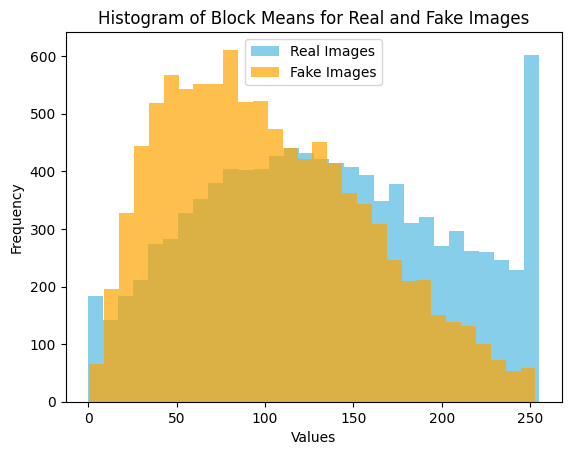

In [8]:
import matplotlib.pyplot as plt 

# Load the means, variances, and labels for fake and real images
fake_images_m, fake_images_v, fake_labels = load_imgs_from_directory(fake_dir, 0, num_images=num_images_to_load)
real_images_m, real_images_v, real_labels = load_imgs_from_directory(real_dir, 1, num_images=num_images_to_load)

# Iterate through the first 8 blocks and calculate statistics for real and fake images
for j in range(8):
    # Extract the j-th block mean from real and fake images
    a = [i[j] for i in real_images_m]
    b = [i[j] for i in fake_images_m]
    
    # Print mean and standard deviation statistics for the j-th block
    print("Mean of " + str(j+1) + "th block of real images :- " + str(np.mean(a)))
    print("Mean of " + str(j+1) + "th block of fake images :- " + str(np.mean(b)))
    print("Std of " + str(j+1) + "th block of real images :- " + str(np.std(a)))
    print("Std of " + str(j+1) + "th block of fake images :- " + str(np.std(b)))

# Plot histograms of the first block mean values for real and fake images
a = [i[0] for i in real_images_m]
b = [i[0] for i in fake_images_m]

plt.hist(x=a, bins=30, color='skyblue', label='Real Images')
plt.hist(x=b, bins=30, color='orange', alpha=0.7, label='Fake Images')  # Adding alpha for better overlap visualization

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Block Means for Real and Fake Images')
plt.legend()  # Adding legend to differentiate between real and fake images
plt.show()


In [9]:
def feature_vec(mean, var):
    # Initialize an empty list to store the feature vectors
    a = []
    
    # Iterate through the mean and variance lists simultaneously
    for i, j in zip(mean, var):
        # Initialize a temporary list to hold the combined features for each image
        b = []
        # Combine the mean and variance for each block into a single vector
        for k, l in zip(i, j):
            b.append(k)  # Append the mean value
            b.append(l)  # Append the variance value
        a.append(b)  # Append the combined vector for the current image
    
    # Return the list of feature vectors
    return a


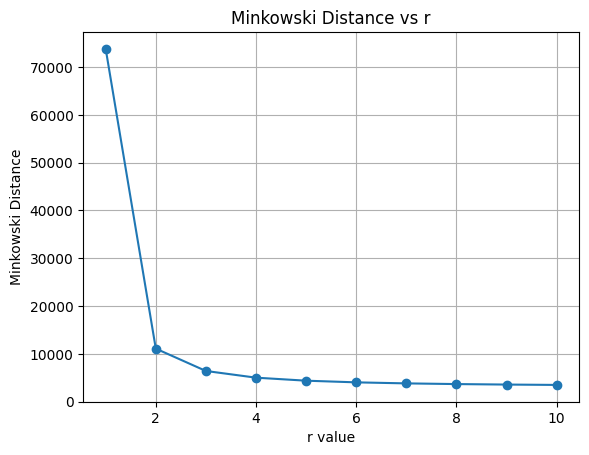

In [10]:
from scipy.spatial.distance import minkowski
import matplotlib.pyplot as plt

# Convert mean and variance features into feature vectors for real and fake images
real_feat_vec = feature_vec(real_images_m, real_images_v)
fake_feat_vec = feature_vec(fake_images_m, fake_images_v)

# Define a range of r values for the Minkowski distance calculation
r_values = range(1, 11)

# Calculate the Minkowski distance between the first feature vector of real and fake images for each r value
distances = [minkowski(real_feat_vec[0], fake_feat_vec[0], r) for r in r_values]

# Plot the Minkowski distance against r values
plt.plot(r_values, distances, marker='o')
plt.xlabel('r value')
plt.ylabel('Minkowski Distance')
plt.title('Minkowski Distance vs r')
plt.grid(True)
plt.show()


In [11]:
# Convert mean and variance features into feature vectors for real and fake images
features_real = feature_vec(real_images_m, real_images_v)
features_vec = feature_vec(fake_images_m, fake_images_v)

# Combine feature vectors and corresponding labels into a single dataset
features = np.vstack((features_real, features_vec))
labels = np.concatenate((fake_labels, real_labels))

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.5, random_state=5)

# Initialize and train the K-Nearest Neighbors classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

# Evaluate the classifier's accuracy on the test set
accuracy = knn.score(x_test, y_test)
print("Accuracy:", accuracy)

# Evaluate the classifier's accuracy on the training set
training_accuracy = knn.score(x_train, y_train)
print(f"Training Accuracy: {training_accuracy}")

# Predict the labels for the first 20 samples in the test set
predictions = knn.predict(x_test[:20])
actual_labels = y_test[:20]

# Create a DataFrame to compare predicted labels with actual labels
predicted_vs_actual = pd.DataFrame({"Actual": actual_labels, "Predicted": predictions})
predicted_vs_actual


Accuracy: 0.6635
Training Accuracy: 0.8299


,Actual,Predicted
0,1,1
1,0,1
2,0,1
3,0,0
4,1,1
5,0,0
6,0,0
7,0,1
8,0,0
9,0,0


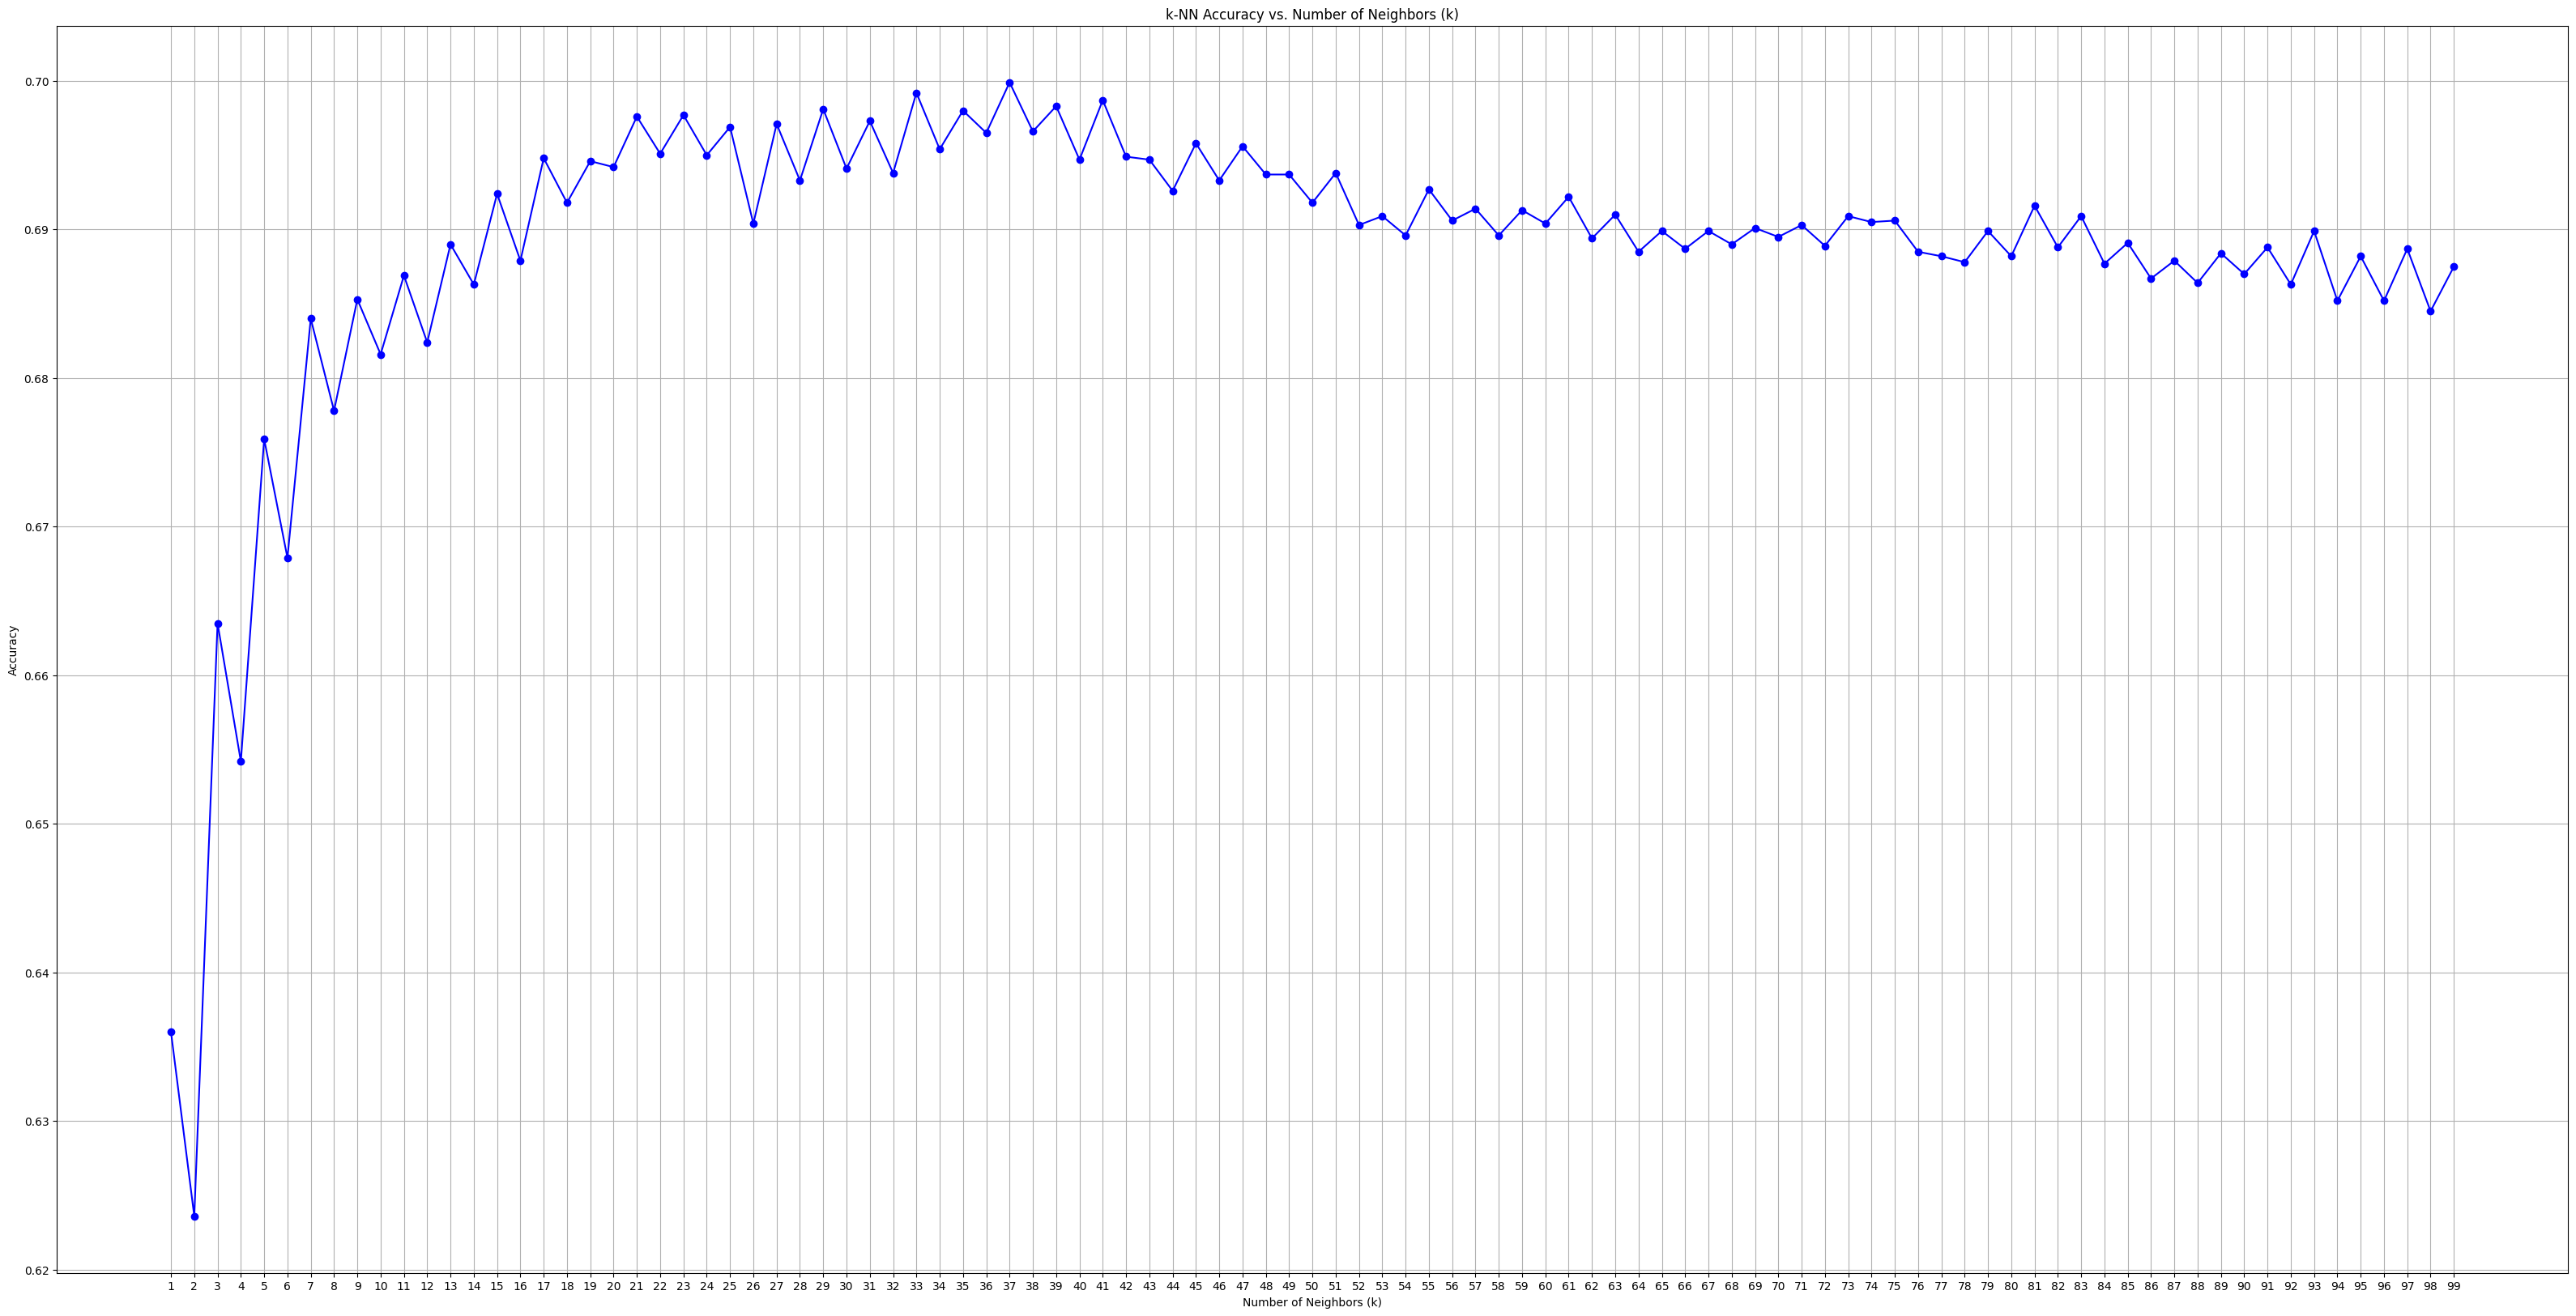

,K-Value,Accuracy
1,1,0.6360
2,2,0.6236
3,3,0.6635
4,4,0.6542
5,5,0.6759
...,...,...
95,95,0.6882
96,96,0.6852
97,97,0.6887
98,98,0.6845


In [12]:
k_values = range(1, 100)
accuracies = []

import matplotlib.pyplot as plty

# Iterate over a range of k values to determine the best number of neighbors for the k-NN classifier
for k in k_values:
    # Initialize the K-Nearest Neighbors classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Train the classifier
    knn.fit(x_train, y_train)
    
    # Predict the labels for the test set
    y_pred = knn.predict(x_test)
    
    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the accuracy to the list
    accuracies.append(accuracy)
    # print(f"Accuracy for k={k}: {accuracy}")  

# Create a DataFrame to store k values and corresponding accuracies
accuracies_df = pd.DataFrame({"K-Value": k_values, "Accuracy": accuracies}, index=k_values)

# Plot accuracy vs. number of neighbors (k)
plty.figure(figsize=(40, 20))
plty.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plty.title('k-NN Accuracy vs. Number of Neighbors (k)')
plty.xlabel('Number of Neighbors (k)')
plty.ylabel('Accuracy')
plty.xticks(k_values)
plty.grid(True)
plty.show()

# Display the DataFrame containing k values and accuracies
accuracies_df


In [13]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Calculate the confusion matrix for the predictions on the test set
conf_mat = confusion_matrix(y_test, y_pred)

# Calculate precision, recall, and F1 score for the predictions
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f_score = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Confusion Matrix:\n{conf_mat}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f_score}")


Confusion Matrix:
[[4176  837]
 [2288 2699]]
Precision: 0.7632918552036199
Recall: 0.5412071385602567
F1 Score: 0.633345066291212
